In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'modulation_index'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
for session in ['2_odor_expo', 'pre', 'post', 'ext1', 'ext2', 'renew']:

    exec('vars_%s = {}'%session)
    folder = '../%s/notebooks/autorestore/preprocessing/'%session
    for var in ('time_ax', 'time_ax_single', 'traces', 'cycles',  'areas',
                'CS_DURATION', 'DELAY', 'is_CSmt', 'is_rewardt'): 
        eval("vars_%s"%session).update({var:ut.load_variable(var, folder=folder)})


In [7]:
# conditions = ['day1', 'day2']
# cellregs = dict(zip(conditions, [ut.load_cellreg_dict('../data/cellreg_dict.txt', c) for c in conditions]))

In [8]:
import scipy.stats as sstats

In [9]:
from skimage.measure import find_contours
from skimage import exposure
from matplotlib.patches import Polygon

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
pvalue = 0.05
# tuned_pre_rew = ut.adjust_pvalues([s[0][1] for s in vars_pre['selectivity']['reward_4s_us']])<pvalue
# tuned_pre_sho = ut.adjust_pvalues([s[0][1] for s in vars_pre['selectivity']['shock_4s_us']])<pvalue
# tuned_post_rew = ut.adjust_pvalues([s[0][1] for s in vars_post['selectivity']['reward_4s_us']])<pvalue
# tuned_post_sho = ut.adjust_pvalues([s[0][1] for s in vars_post['selectivity']['shock_4s_us']])<pvalue

In [12]:
def compute_modulation_index(time_ax, traces, cycles, time_ax_single, STIM_START, STIM_DURATION, is_odor, t_base=2):
    hm = np.r_[[ut.compute_all_dffs(time_ax, traces, cell, cycles[is_odor], time_ax_single)\
                        for cell in range(traces.shape[1])]]
    hm = np.r_[[np.mean(h, 0)/np.std(h, 0) for h in hm]]
    time_filter = (time_ax_single >= STIM_START) * (time_ax_single < (STIM_START + STIM_DURATION))
    stim_resp = hm[:, time_filter].mean(1)
    time_filter = (time_ax_single >= (STIM_START - t_base)) * (time_ax_single < STIM_START )
    base_resp = hm[:, time_filter].mean(1)
#     print zip(base_resp, stim_resp)
    return (stim_resp-base_resp)/base_resp*100.

In [13]:
def compute_modulation_index_1s(time_ax, traces, cycles, time_ax_single, STIM_START, STIM_DURATION, is_odor, t_base=1):
    hm = np.r_[[ut.compute_all_dffs(time_ax, traces, cell, cycles[is_odor], time_ax_single)\
                        for cell in range(traces.shape[1])]]
    hm = np.r_[[np.mean(h, 0)/np.std(h, 0) for h in hm]]
    time_filter = (time_ax_single >= STIM_START) * (time_ax_single < (STIM_START + STIM_DURATION))
    stim_resp = hm[:, time_filter].mean(1)
    time_filter = (time_ax_single >= -2) * (time_ax_single < -1 )
    base_resp = hm[:, time_filter].mean(1)
#     print zip(base_resp, stim_resp)
    return (stim_resp-base_resp)/base_resp*100.

In [14]:
from itertools import product

In [15]:
prod = product(['2_odor_expo', 'pre', 'post', 'ext1', 'ext2', 'renew'], ['CSmt', 'rewardt'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_%s_%s = np.nan_to_num(compute_modulation_index(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            0,\
                                            v['CS_DURATION'],\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

In [16]:
prod = product(['2_odor_expo', 'pre', 'post','ext1', 'ext2', 'renew'], ['CSmt', 'rewardt'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_only_tra%s_%s = np.nan_to_num(compute_modulation_index(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            v['CS_DURATION'],\
                                            v['DELAY'],\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

In [17]:
prod = product(['2_odor_expo', 'pre', 'post', 'ext1', 'ext2', 'renew'], ['CSmt', 'rewardt'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_%s_%s_1s = np.nan_to_num(compute_modulation_index_1s(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            1,\
                                            2,\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

In [18]:
prod = product(['2_odor_expo', 'pre', 'post','ext1', 'ext2', 'renew'], ['CSmt', 'rewardt'])

for session, odor in prod:
    v = eval("vars_%s"%session)
    exec("mod_inds_only_tra%s_%s_1s = np.nan_to_num(compute_modulation_index_1s(v['time_ax'],\
                                            v['traces'],\
                                            v['cycles'],\
                                            v['time_ax_single'],\
                                            3,\
                                            4,\
                                            is_odor=v['is_%s']))"%(odor, session, odor))

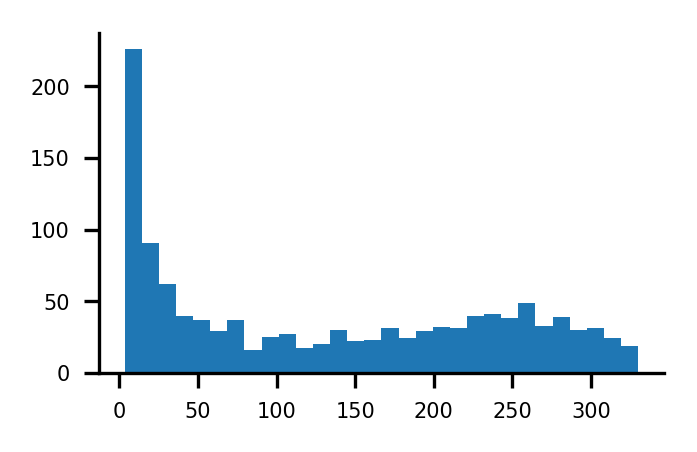

In [19]:
pl.hist(vars_pre['areas'][0].flatten()[np.nonzero(vars_pre['areas'][0].flatten())],bins=30);

In [20]:
# pl.style.use('white_background')
def plot_activity(vars_pre, odor='rewardt', tuned=None, with_untuned=True, ax=None, prepost='pre', period='only_tra',oneSec=False,
                  vmin=-75, vmax=75):
    
#     exec("vars_pre = vars_%s"%prepost)
    areas = vars_pre['areas'].copy()

    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(3, 3))

    if tuned is None:
        tuned = [False]*len(areas)
    for cell in range(len(areas)):
#         p10 = np.percentile(areas[cell][np.nonzero(areas[cell])], 10)
#         p90 = np.percentile(areas[cell][np.nonzero(areas[cell])], 90)
        a = exposure.rescale_intensity(areas[cell], in_range=(np.min(areas[cell]), np.max(areas[cell])))
        contours = np.r_[find_contours(a, 0.01)]
        polygon = Polygon(contours[np.argmax([len(c) for c in contours])],
                          color=(0, 0, 0, 0), lw=0.5 if tuned[cell] else 0.1 if with_untuned else 0,
                          ec='k',
                          closed=False, zorder=19)
        ax.add_patch(polygon)
    # im = np.zeros_like(areas[0])

    # for a in areas:
    #     a = exposure.rescale_intensity(a, in_range=(0.2, 0.4))
    #     im += a
    # im = np.clip(im, 0, .2)
    # ax.imshow(im, pl.cm.gray, vmin=0, vmax=1)

    im2 = np.zeros_like(areas[0])
    for i, a in enumerate(areas):
    #     a = exposure.rescale_intensity(a, in_range=(0.2, 0.4))
        aa = a-np.min(a)
        aa /= np.max(aa)
#         aa *= 2
#         aa -= 1
        
#         a *= zz[vars_pre['labels']==odor][:, i].mean(0)
        if oneSec == True:
            a = aa*eval("mod_inds_%s%s_%s_1s"%(period, odor, prepost))[i]
        if oneSec == False:
            a = aa*eval("mod_inds_%s%s_%s"%(period, odor, prepost))[i]
    #     a[a==0] = np.nan
        im2 += a

    # im2 /= 100.    
    im2[im2 == 0] = np.nan
    im2 = ax.imshow(im2.T, cmap=pl.cm.bwr, vmin=vmin, vmax=vmax)

    ax.set_xticks(())
    ax.set_yticks(());

    
    return im2

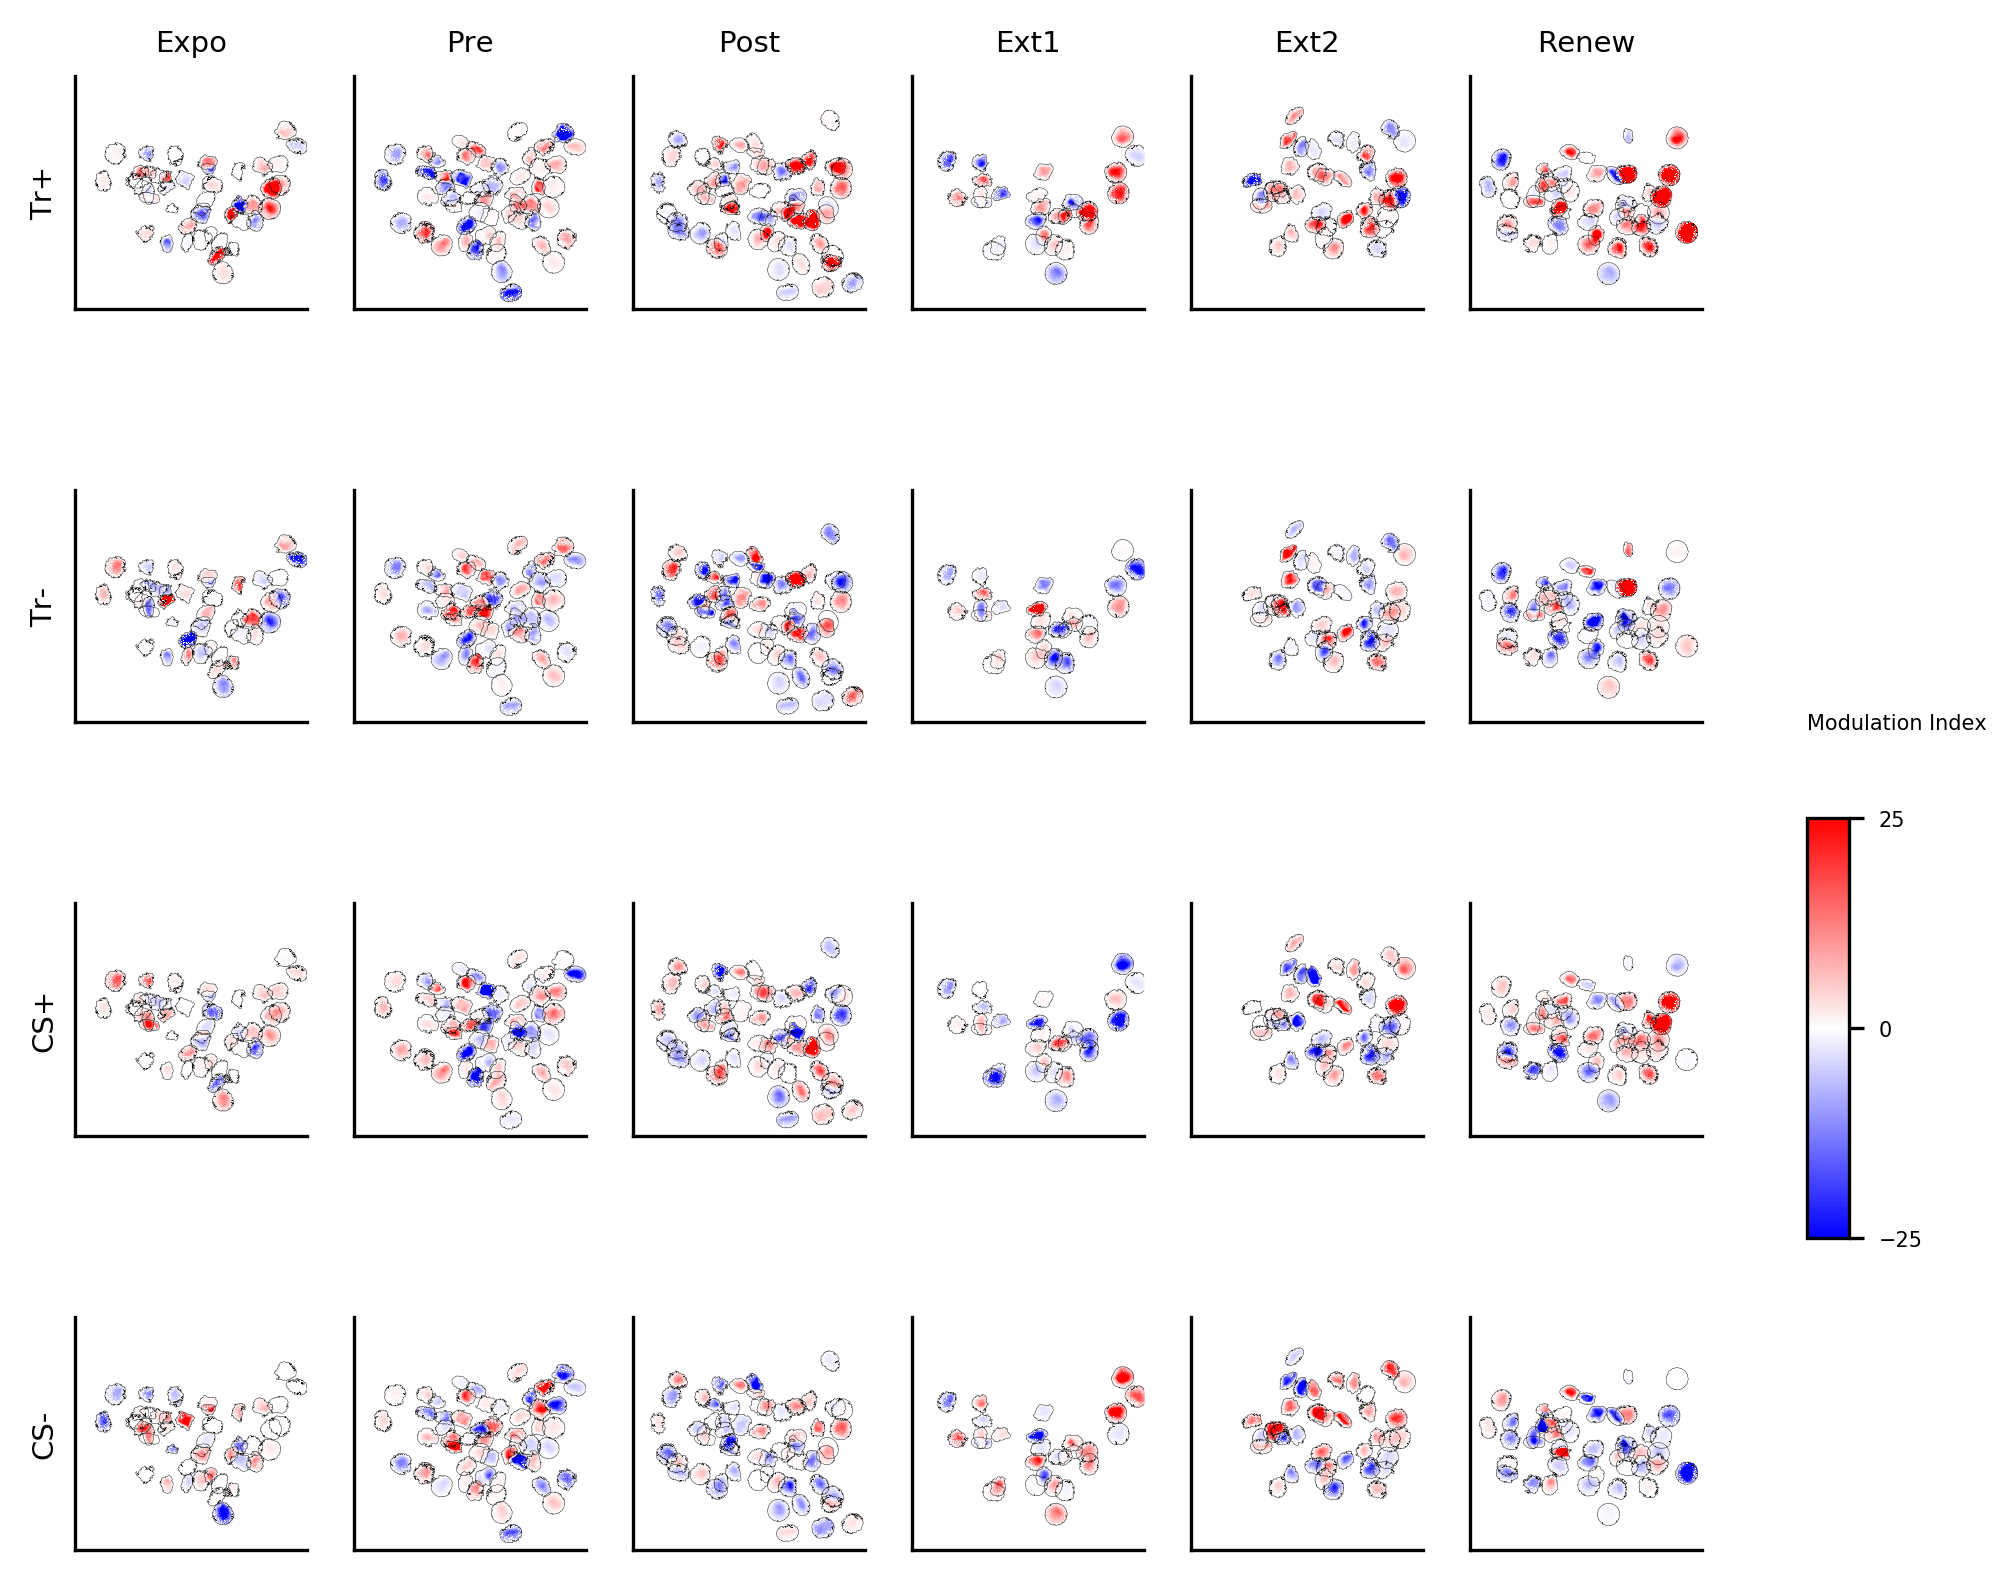

In [21]:
abs_vmax_vmin = 25

fig, axs = pl.subplots(4, 6, figsize=(7, 7))
#plotting trace responses
plot_activity(vars_2_odor_expo, ax=axs[0][0], prepost='2_odor_expo', with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[0][1], with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[0][2], prepost='post', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[0][3], prepost='ext1', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[0][4], prepost='ext2', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[0][5], prepost='renew', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_2_odor_expo, ax=axs[1][0], odor='CSmt', prepost='2_odor_expo', with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[1][1], odor='CSmt', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[1][2], odor='CSmt', prepost='post', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[1][3], odor='CSmt', prepost='ext1', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[1][4], odor='CSmt', prepost='ext2', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[1][5], odor='CSmt', prepost='renew', with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)

#plotting CS responses
plot_activity(vars_2_odor_expo, ax=axs[2][0], prepost='2_odor_expo', period='',with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[2][1], period='',with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[2][2], prepost='post', period='',with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[2][3], prepost='ext1', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[2][4], prepost='ext2', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[2][5], prepost='renew', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_2_odor_expo, ax=axs[3][0], odor='CSmt', prepost='2_odor_expo', period='',with_untuned=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[3][1], odor='CSmt',period='', with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[3][2], odor='CSmt', prepost='post', period='',with_untuned=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[3][3], odor='CSmt', prepost='ext1', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[3][4], odor='CSmt', prepost='ext2', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[3][5], odor='CSmt', prepost='renew', period='',with_untuned=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)

ax = fig.add_axes((0.95, 0.3, 0.02, 0.2))

fig.colorbar(im2, cax=ax, ticks=(-abs_vmax_vmin, 0, abs_vmax_vmin))

axs[0][0].set_title('Expo')
axs[0][1].set_title('Pre')
axs[0][2].set_title('Post')
axs[0][3].set_title('Ext1')
axs[0][4].set_title('Ext2')
axs[0][5].set_title('Renew')


# fig.suptitle('Mean Event Rate\n(s.d.)', x=0.95, y=0.55, fontsize=5, ha='left')
fig.suptitle('Modulation Index', x=0.95, y=0.55, fontsize=5, ha='left')

axs[0][0].set_ylabel('Tr+')
axs[1][0].set_ylabel('Tr-')
axs[2][0].set_ylabel('CS+')
axs[3][0].set_ylabel('CS-')

fig.savefig('../img/modulation_index.pdf')

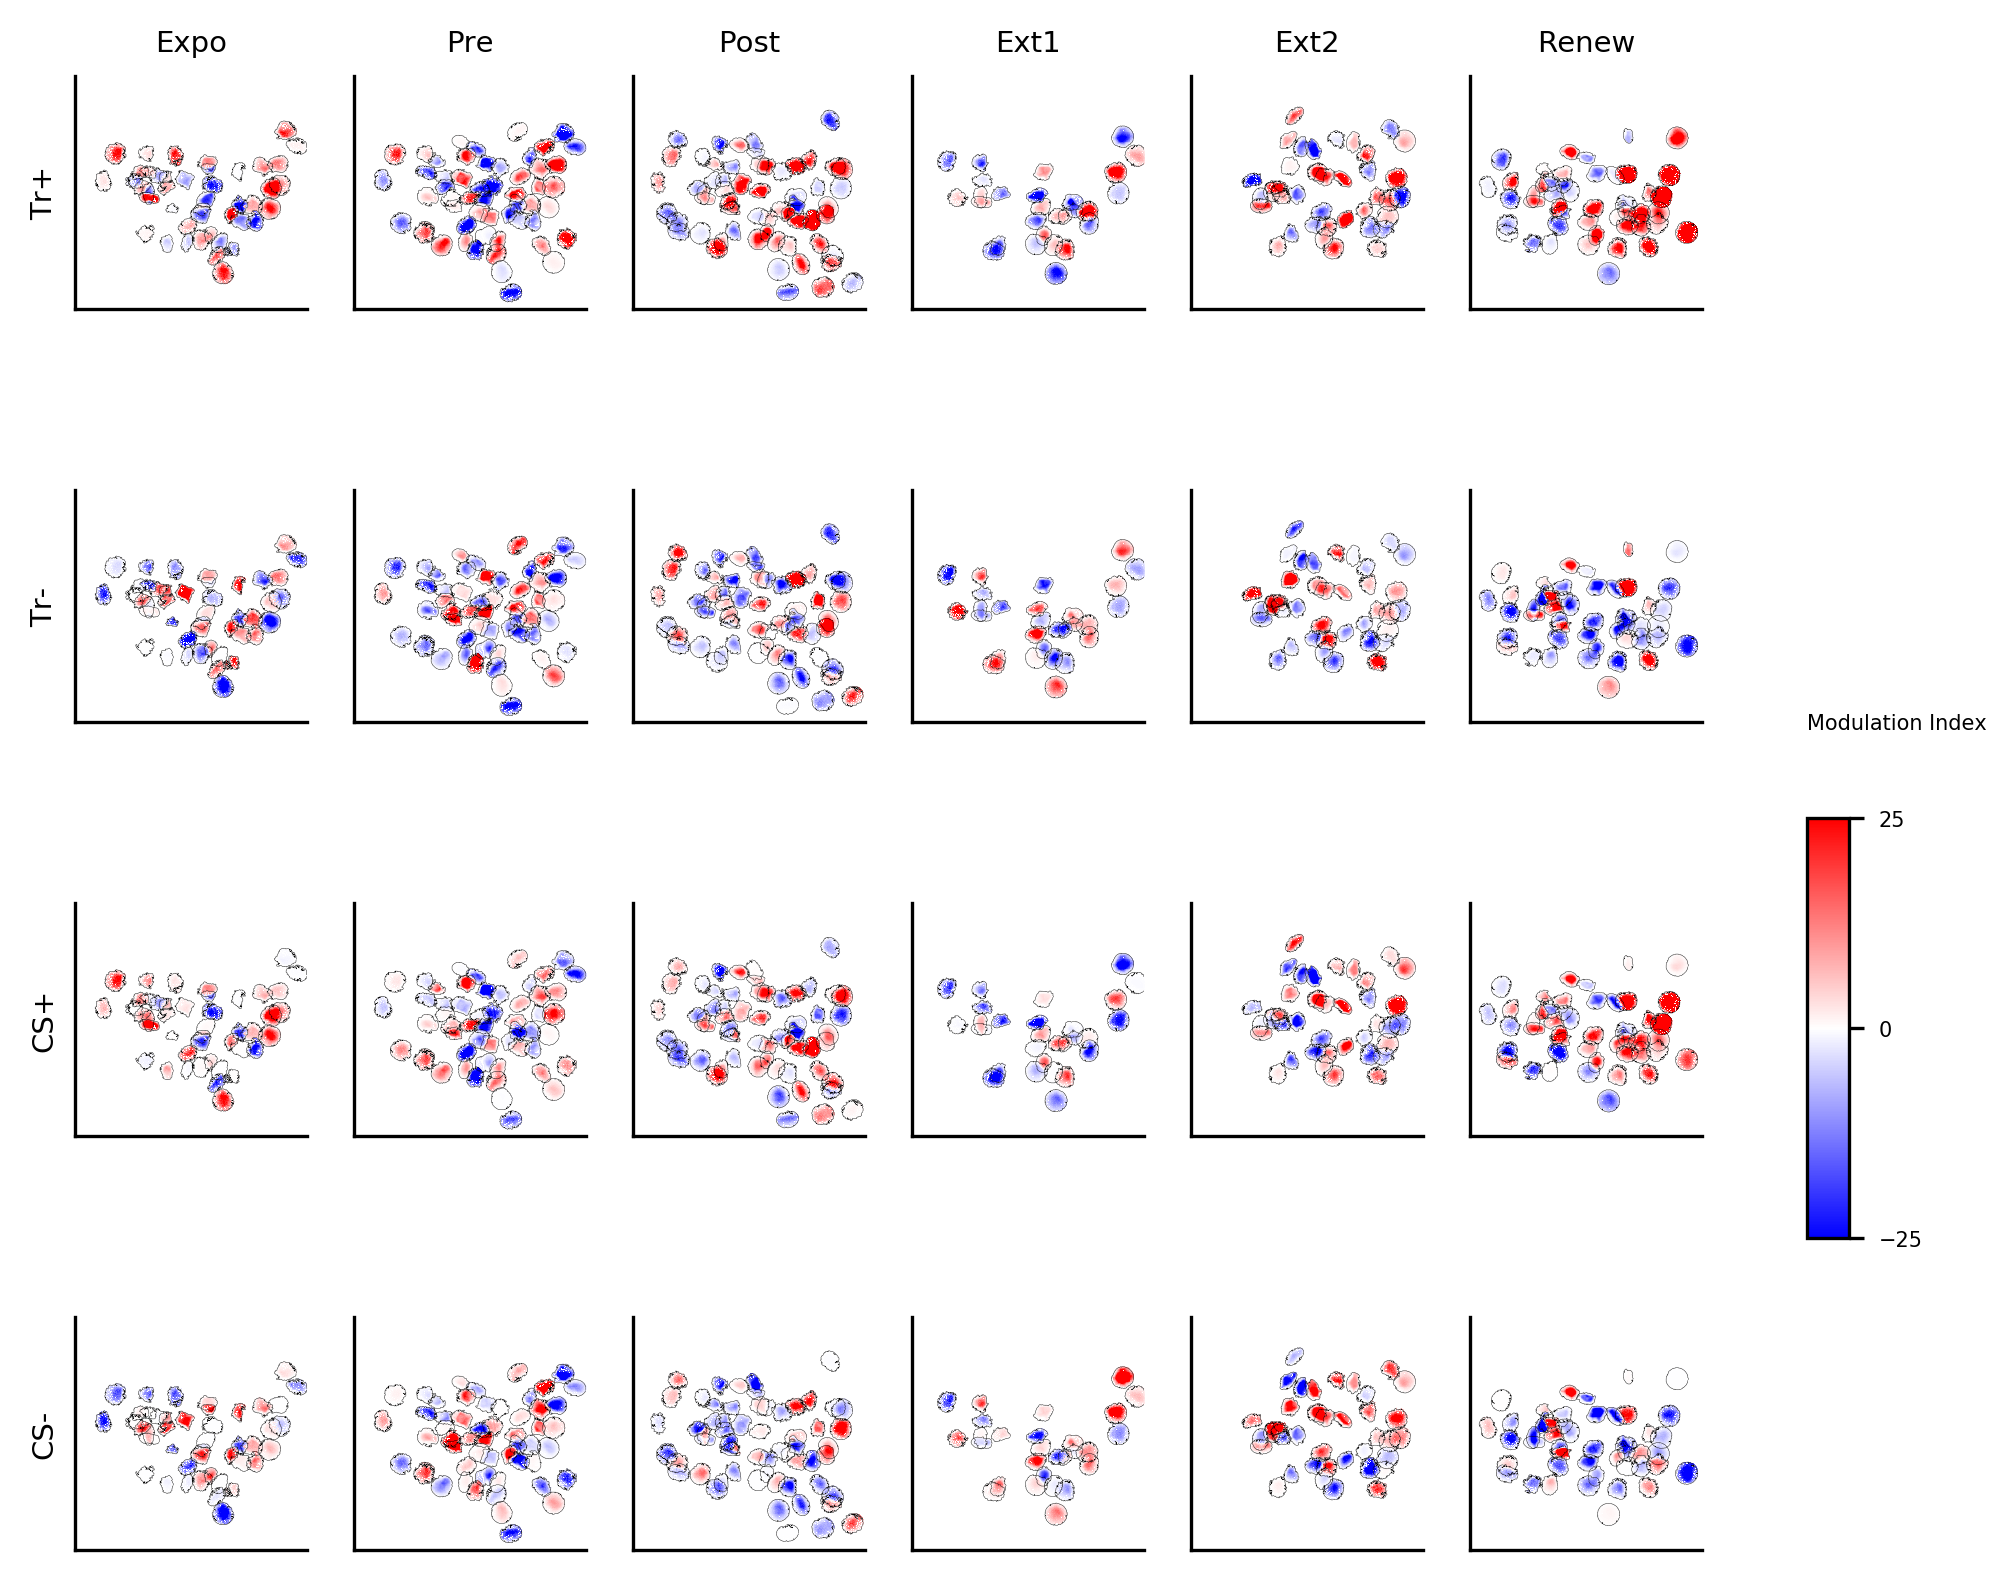

In [22]:
abs_vmax_vmin = 25

fig, axs = pl.subplots(4, 6, figsize=(7, 7))
#plotting trace responses
plot_activity(vars_2_odor_expo, ax=axs[0][0], prepost='2_odor_expo', with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[0][1], with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[0][2], prepost='post', with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[0][3], prepost='ext1', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[0][4], prepost='ext2', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[0][5], prepost='renew', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_2_odor_expo, ax=axs[1][0], odor='CSmt', prepost='2_odor_expo', with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[1][1], odor='CSmt', with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[1][2], odor='CSmt', prepost='post', with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[1][3], odor='CSmt', prepost='ext1', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[1][4], odor='CSmt', prepost='ext2', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[1][5], odor='CSmt', prepost='renew', with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)

#plotting CS responses
plot_activity(vars_2_odor_expo, ax=axs[2][0], prepost='2_odor_expo', period='',with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[2][1], period='',with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[2][2], prepost='post', period='',with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[2][3], prepost='ext1', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[2][4], prepost='ext2', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[2][5], prepost='renew', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_2_odor_expo, ax=axs[3][0], odor='CSmt', prepost='2_odor_expo', period='',with_untuned=True, oneSec=True,
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_pre, ax=axs[3][1], odor='CSmt',period='', with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
plot_activity(vars_post, ax=axs[3][2], odor='CSmt', prepost='post', period='',with_untuned=True, oneSec=True, 
              vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext1, ax=axs[3][3], odor='CSmt', prepost='ext1', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_ext2, ax=axs[3][4], odor='CSmt', prepost='ext2', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)
im2 = plot_activity(vars_renew, ax=axs[3][5], odor='CSmt', prepost='renew', period='',with_untuned=True, oneSec=True, 
                    vmin=-abs_vmax_vmin, vmax=abs_vmax_vmin)

ax = fig.add_axes((0.95, 0.3, 0.02, 0.2))

fig.colorbar(im2, cax=ax, ticks=(-abs_vmax_vmin, 0, abs_vmax_vmin))

axs[0][0].set_title('Expo')
axs[0][1].set_title('Pre')
axs[0][2].set_title('Post')
axs[0][3].set_title('Ext1')
axs[0][4].set_title('Ext2')
axs[0][5].set_title('Renew')


# fig.suptitle('Mean Event Rate\n(s.d.)', x=0.95, y=0.55, fontsize=5, ha='left')
fig.suptitle('Modulation Index', x=0.95, y=0.55, fontsize=5, ha='left')

axs[0][0].set_ylabel('Tr+')
axs[1][0].set_ylabel('Tr-')
axs[2][0].set_ylabel('CS+')
axs[3][0].set_ylabel('CS-')

fig.savefig('../img/modulation_index_1s.pdf')

In [23]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'exposure'. Skipping...
